In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib
import keras

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

2025-08-26 20:57:03.508035: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 20:57:03.525006: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 20:57:03.660388: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 20:57:03.775656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756234623.862540  246603 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756234623.88

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/ronan/code/Power_Price_Forecasting/scripts/preprocess_att.py:709: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month'] = df['datetime'].dt.to_period('M')


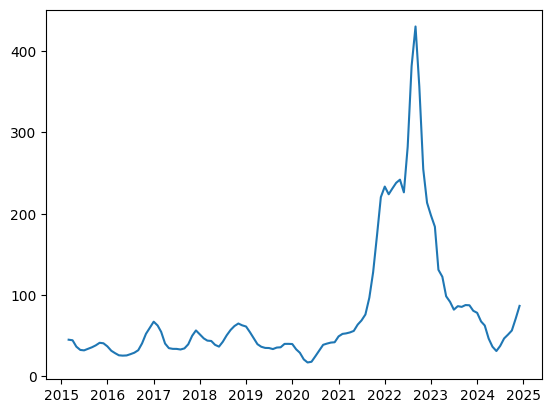

In [2]:
model_data = pd.read_csv(os.path.join(DATA_PATH, 'ATT', 'model_data.csv'))

from scripts.preprocess_att import monthly_statistics

monthly_stats = monthly_statistics(model_data)

plt.plot(monthly_stats.index, monthly_stats['3-Month Rolling Average'])

# 1. Import processed data

In [3]:
data_dir = os.path.join(DATA_PATH, 'ATT', 'full_set')

X_past = np.load(os.path.join(data_dir, 'X_past.npy'))
X_future = np.load(os.path.join(data_dir, 'X_future.npy'))

X_past_transformed = np.load(os.path.join(data_dir, 'X_past_transformed.npy'))
X_future_transformed = np.load(os.path.join(data_dir, 'X_future_transformed.npy'))

y = np.load(os.path.join(data_dir, 'y.npy'))

past_times = pd.read_pickle(os.path.join(data_dir, 'past_times.pkl'))
future_times = pd.read_pickle(os.path.join(data_dir, 'future_times.pkl'))


# 2. Forecast with simple LSTM

In [4]:
from scripts.model_lstm import LSTMModel

lstm_model = LSTMModel(
    # LSTM parameters
    lstm_units=32,        # Good starting point: ~2-4x number of features
    dense_units=16,        # Half of LSTM units for dimensionality reduction

    # Input dimensions (from your data)
    n_past_features=X_past_transformed.shape[2],
    n_future_features=X_future_transformed.shape[2],
    past_seq_len=X_past_transformed.shape[1],
    future_seq_len=X_future_transformed.shape[1],

    # Regularization
    dropout=0.3,           # Moderate dropout to prevent overfitting
    batch_normalization=True,

    # Training parameters
    learning_rate=0.001,   # Standard learning rate for Adam
    verbose=True,
    epochs_early_stopping=20,

    # Loss and metrics
    loss='mse',
    metrics=['mae', 'mape'],

    # Additional regularization
    regularization='l2',
    lambda_reg=0.01       # Small L2 penalty
)

lstm_model

2025-08-26 20:57:09.768734: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
X_past_transformed.shape

(2214, 168, 21)

In [9]:
X_future_transformed.shape

(2214, 24, 27)

Epoch 1/1000


2025-08-26 20:57:13.648740: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 13033.1953 - mae: 77.9706 - mape: 4869749.5000 - val_loss: 12942.5244 - val_mae: 78.7388 - val_mape: 6455681.5000 - learning_rate: 0.0010
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 12014.5176 - mae: 77.5067 - mape: 7405608.0000 - val_loss: 12584.0420 - val_mae: 79.1016 - val_mape: 23515018.0000 - learning_rate: 0.0010
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 12042.6396 - mae: 75.8664 - mape: 18663214.0000 - val_loss: 12164.4502 - val_mae: 78.9538 - val_mape: 37454472.0000 - learning_rate: 0.0010
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 11963.1924 - mae: 77.9000 - mape: 28651346.0000 - val_loss: 11600.3662 - val_mae: 78.3426 - val_mape: 50283264.0000 - learning_rate: 0.0010
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 11015.7949 - mae: 74.2975 - mape: 24891306.0000 - val_loss: 11130.5049 - val_mae: 77.5600 - val_mape: 55317384.0000 - learning_rate: 0.0010
Epoch 6/100

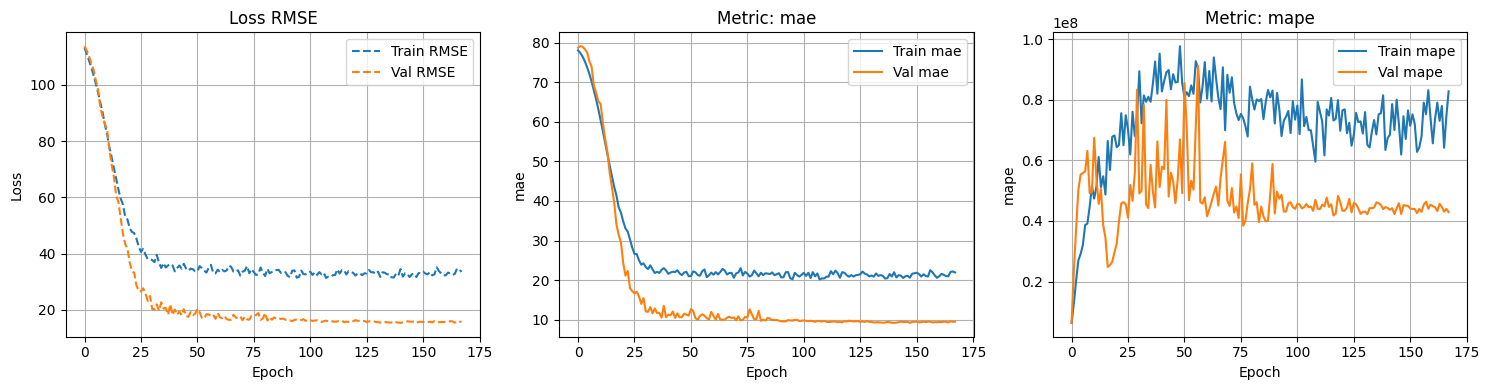

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 121.3438 - mae: 6.0941 - mape: 6591512.5000
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 121.3438 - mae: 6.0941 - mape: 6591512.5000

Final Training Metrics:
RMSE: 15.3930
['mae', 'mape']: [9.198577880859375, 45246420.0]

Final Validation Metrics:
RMSE: 15.3930
['mae', 'mape']: [9.198577880859375, 45246420.0]


In [5]:
lstm_model.fit(X_past_transformed, X_future_transformed, y, 
            X_past_transformed, X_future_transformed, y)


In [6]:
from scripts.config import LOGS_PATH
%tensorboard --logdir {LOGS_PATH}/LSTM/fit